In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import BatchNormalization

In [153]:
participant_file_names = []
participants = []
for i in range(1,16):
    participant_file_names.append(np.genfromtxt('%i.csv'%(i), delimiter=','))
    participants.append(np.genfromtxt('%i.csv'%(i), delimiter=','))


In [154]:
participants_train = participants[:2]

In [174]:
import pandas as pd
from scipy.stats import mode
n=0
p = 50
TIME_PERIODS = p
num_sensors = 3
Y = []
X = []
 
for j in range(1, num_sensors+1):
    x = []
    
    for k in range(len(participants_train)):
        x_participant = pd.DataFrame(participants_train[k][:,j])
        x_participant = pd.concat([x_participant.shift(i) for i in range(p)], axis=1).dropna()
        x.append(x_participant)
        
    
    x = np.vstack(x)
    x = np.expand_dims(x,2)
    
    X.append(x.T)

    
y = [] 
for k in range(len(participants_train)): 
    y_participant = pd.DataFrame(participants_train[k][:,4])
    y_participant = y_participant[p-1:]
    y.append(y_participant)
    
y = np.vstack(y)
y = y.flatten()

In [175]:
X = np.array(X).squeeze()


In [194]:
y

array([1., 1., 1., ..., 7., 7., 0.])

In [176]:
X = X.T

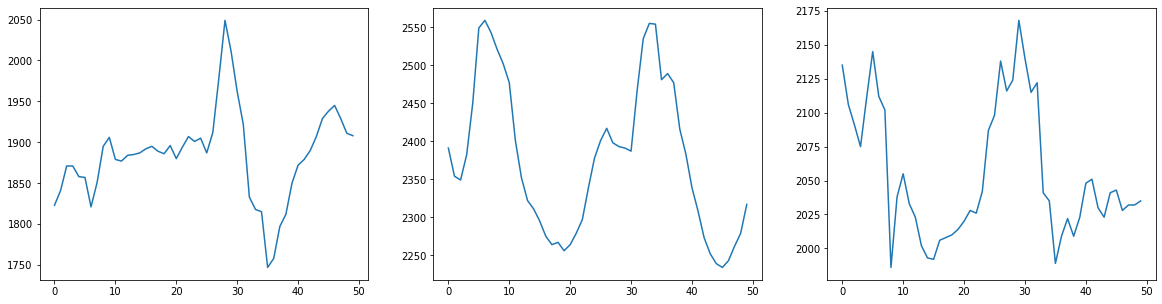

In [179]:
fig, ax = plt.subplots(1, num_sensors, figsize=[20, 5])
for i in range(len(ax)):
    ax[i].plot(X[50000, :, i])

In [180]:
y.shape

(300404,)

In [181]:
n_filters = 4
filter_size = 3
pool_size = 2

In [182]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
print(tf.__version__)


2.4.1


In [183]:
tf.keras.backend.clear_session()

In [192]:
tf.random.set_seed(1)

model = tf.keras.models.Sequential([
    #tf.keras.Input(input_shape=(TIME_PERIODS,num_sensors)),
    tf.keras.layers.Reshape((TIME_PERIODS, num_sensors), input_shape=(TIME_PERIODS,num_sensors)),
    BatchNormalization(),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu', 
                           padding='same',input_shape=(TIME_PERIODS, num_sensors),
                          name='conv1'),
    tf.keras.layers.Conv1D(n_filters, filter_size, padding='same', 
                           activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling1D(pool_size, name='maxpool'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(y_binary.shape[1], activation='softmax')
])
 
    
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 50, 3)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 3)             12        
_________________________________________________________________
conv1 (Conv1D)               (None, 50, 4)             40        
_________________________________________________________________
conv2 (Conv1D)               (None, 50, 4)             52        
_________________________________________________________________
maxpool (MaxPooling1D)       (None, 25, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

In [193]:
model.fit(X, y_binary,epochs=1, batch_size=64, verbose=1)

4694/4694 [==============================] - 16s 3ms/step - loss: 0.7222 - accuracy: 0.7730


In [186]:
X.shape

(300404, 50, 3)

In [187]:
from tensorflow.keras.models import Model
 
layer_name = "conv2"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(name=layer_name).output)

# get the data into the correct shape for the model
x_predict = X[50000,:,:]
x_predict = np.expand_dims(x_predict,0)
intermediate_output = intermediate_layer_model.predict(x_predict)

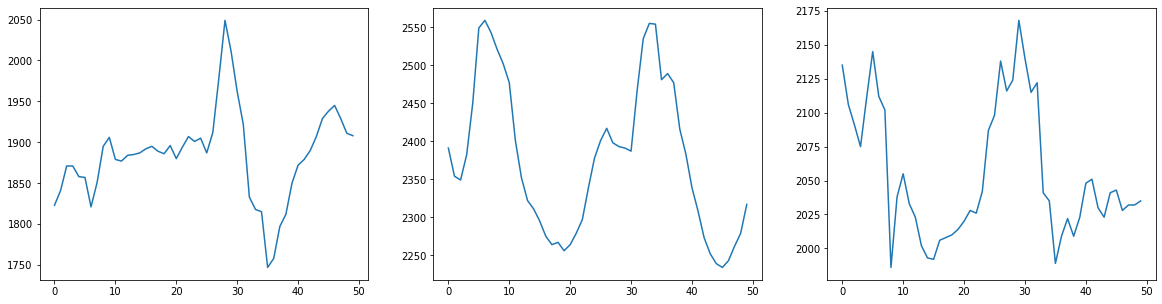

In [190]:
fig, ax = plt.subplots(1, num_sensors, figsize=[20, 5])
for i in range(num_sensors):
    ax[i].plot(x_predict[0][:, i])


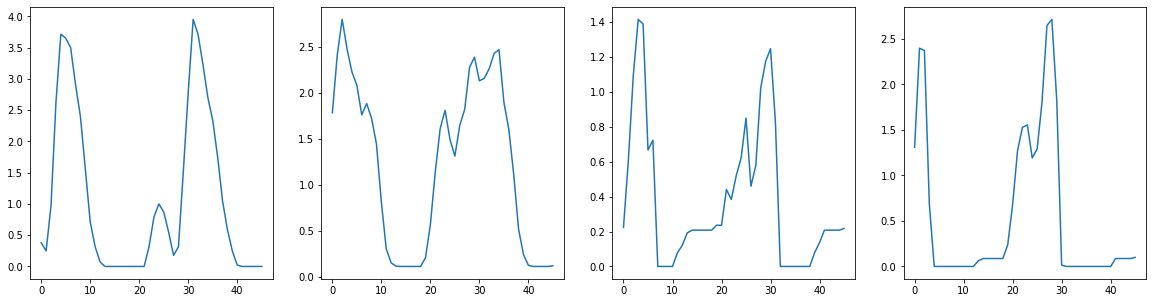

In [191]:
fig, ax = plt.subplots(1, 4, figsize=[20, 5])
for i in range(4):
    ax[i].plot(intermediate_output[0,:, i])

In [ ]:
plt.plot(x_predict[0, :, 0])
plt.title('Input to Network')

In [96]:
x_predict[0].shape

(50, 2)

In [98]:
intermediate_output.shape

(1, 48, 4)

In [ ]:
# evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=64, verbose=0)